<a href="https://colab.research.google.com/github/hmyrcmn/bitirme/blob/main/deneme1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch numpy


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [6]:
from google.colab import files
import json


# Yüklenen dosyaları okuyun
cv_file = "/content/cv.json"
startup_file = "/content/Startup.json"

with open(cv_file, 'r') as f:
    cv_data = json.load(f)

with open(startup_file, 'r') as f:
    startup_data = json.load(f)


In [7]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# BERT modelini ve tokenizer'ını yükleyin
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

 get_embedding fonksiyonu, BERT modelinin sadece son gizli katmanının çıkışını kullanarak özellik çıkarır. Bu durumda, modelin en son katmanından elde edilen çıkışlar kullanılır.

In [14]:
import json

# JSON dosyalarını okuyun
cv_file = "/content/cv.json"  # CV JSON dosyasının yolu
startup_file = "/content/Startup.json"  # Startup JSON dosyasının yolu

with open(cv_file, 'r') as f:
    cv_data = json.load(f)

with open(startup_file, 'r') as f:
    startup_data = json.load(f)

# BERT modelini ve tokenizer'ını yükleyin
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Özellik çıkarma fonksiyonları
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def get_text_from_cv(cv):
    competence = ' '.join(cv.get('competence', []))
    sectors = ' '.join(cv.get('CV Experience & Know How', {}).get('Sectors', []))
    experiences = ' '.join(exp.get('description', '') for exp in cv.get('CV Experience & Know How', {}).get('Experience', []))
    return f"{competence} {sectors} {experiences}"

def get_text_from_startup(startup):
    return f"{startup.get('tags', '')}"

# CV ve startup verilerini gömülü vektörlere dönüştürün
cv_embeddings = [get_embedding(get_text_from_cv(cv)) for cv in cv_data]
startup_embeddings = [get_embedding(get_text_from_startup(startup)) for startup in startup_data]

# Benzerlik hesaplama ve en uygun CV'yi bulma fonksiyonları
def cosine_similarity(vec1, vec2):
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def find_best_cv_for_startup(startup_index):
    startup_embedding = startup_embeddings[startup_index]
    similarities = [cosine_similarity(startup_embedding, cv_embedding) for cv_embedding in cv_embeddings]
    best_cv_index = np.argmax(similarities)
    return cv_data[best_cv_index], similarities[best_cv_index]

# Sonuçları görüntüleyin
for i, startup in enumerate(startup_data):
    best_cv, score = find_best_cv_for_startup(i)
    print(f"Startup: {startup['business_name']}")
    print(f"En uygun CV: {best_cv['name']} (Skor: {score:.2f})")
    print()


Startup: PlayerGo
En uygun CV: Mehmet Ali Şahin (Skor: 0.57)

Startup: CMO Index – Fractional CMO Directory
En uygun CV: Adrian Thoma (Skor: 0.73)

Startup: Inqud
En uygun CV: Tolga Alkan (Skor: 0.70)

Startup: TaxInsight
En uygun CV: Jenny Bartsch (Skor: 0.58)

Startup: LogoYa
En uygun CV: Adrian Thoma (Skor: 0.71)

Startup: Riddep
En uygun CV: Jale Türk (Skor: 0.74)

Startup: Linkhouse
En uygun CV: Bengü İnan (Skor: 0.83)

Startup: Español Chévere
En uygun CV: Bengü Deniz (Skor: 0.67)

Startup: ChatWithCloud
En uygun CV: Alexandra Rudl (Skor: 0.68)

Startup: Health Folder
En uygun CV: Dilek Yıldız (Skor: 0.72)

Startup: Truck1.sg
En uygun CV: Selma Yılmaz (Skor: 0.74)

Startup: 3CHEAPS
En uygun CV: Ulrich Benz (Skor: 0.68)

Startup: RENEWABLE ENERGY HOLDING SA
En uygun CV: Ali Demir (Skor: 0.71)

Startup: RenderLion
En uygun CV: Nilgün Güler (Skor: 0.64)

Startup: Planet Wild
En uygun CV: Yasemin Çelik (Skor: 0.65)

Startup: Zapant
En uygun CV: Cem Kaya (Skor: 0.72)

Startup: 20ROBOT

# mdoel 2

get_embedding_from_layer fonksiyonu, BERT modelinin tüm giriş katmanlarını kullanarak özellik çıkarır. layer_num parametresi, hangi katmanın kullanılacağını belirler

In [15]:
import torch
from transformers import BertTokenizer, BertModel

# BERT modelini ve tokenizer'ını yükleyin
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Özellik çıkarma fonksiyonları
def get_embedding_from_layer(text, layer_num):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs, output_hidden_states=True)
    layer_output = outputs.hidden_states[layer_num]
    return torch.mean(layer_output, dim=1).detach().numpy()

def get_text_from_cv(cv):
    competence = ' '.join(cv.get('competence', []))
    sectors = ' '.join(cv.get('CV Experience & Know How', {}).get('Sectors', []))
    experiences = ' '.join(exp.get('description', '') for exp in cv.get('CV Experience & Know How', {}).get('Experience', []))
    return f"{competence} {sectors} {experiences}"

def get_text_from_startup(startup):
    return f"{startup.get('tags', '')}"

# CV ve startup verilerini gömülü vektörlere dönüştürün
cv_embeddings = [get_embedding_from_layer(get_text_from_cv(cv), layer_num=11) for cv in cv_data] # Örnek olarak 11. katmanı kullanıyoruz
startup_embeddings = [get_embedding_from_layer(get_text_from_startup(startup), layer_num=11) for startup in startup_data]

# Benzerlik hesaplama ve en uygun CV'yi bulma fonksiyonları
def cosine_similarity(vec1, vec2):
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def find_best_cv_for_startup(startup_index):
    startup_embedding = startup_embeddings[startup_index]
    similarities = [cosine_similarity(startup_embedding, cv_embedding) for cv_embedding in cv_embeddings]
    best_cv_index = np.argmax(similarities)
    return cv_data[best_cv_index], similarities[best_cv_index]

# Sonuçları görüntüleyin
for i, startup in enumerate(startup_data):
    best_cv, score = find_best_cv_for_startup(i)
    print(f"Startup: {startup['business_name']}")
    print(f"En uygun CV: {best_cv['name']} (Skor: {score:.2f})")
    print()


Startup: PlayerGo
En uygun CV: Selin Öztürk (Skor: 0.69)

Startup: CMO Index – Fractional CMO Directory
En uygun CV: Rıza Doğan (Skor: 0.80)

Startup: Inqud
En uygun CV: Tolga Alkan (Skor: 0.78)

Startup: TaxInsight
En uygun CV: Jenny Bartsch (Skor: 0.71)

Startup: LogoYa
En uygun CV: Adrian Thoma (Skor: 0.80)

Startup: Riddep
En uygun CV: Jale Türk (Skor: 0.81)

Startup: Linkhouse
En uygun CV: Bengü İnan (Skor: 0.86)

Startup: Español Chévere
En uygun CV: Bengü Deniz (Skor: 0.78)

Startup: ChatWithCloud
En uygun CV: Alexandra Rudl (Skor: 0.80)

Startup: Health Folder
En uygun CV: Dilek Yıldız (Skor: 0.81)

Startup: Truck1.sg
En uygun CV: Günter Meier (Skor: 0.80)

Startup: 3CHEAPS
En uygun CV: Ulrich Benz (Skor: 0.77)

Startup: RENEWABLE ENERGY HOLDING SA
En uygun CV: Ali Demir (Skor: 0.79)

Startup: RenderLion
En uygun CV: Alexandra Rudl (Skor: 0.77)

Startup: Planet Wild
En uygun CV: Can Yılmaz (Skor: 0.79)

Startup: Zapant
En uygun CV: Alexandra Rudl (Skor: 0.78)

Startup: 20ROBOTS

#sonuc görselleştirme

her bir başlangıç için en uygun özgeçmişi ve ona ait benzerlik skorunu yatay çubuk grafiklerle görselleştirir

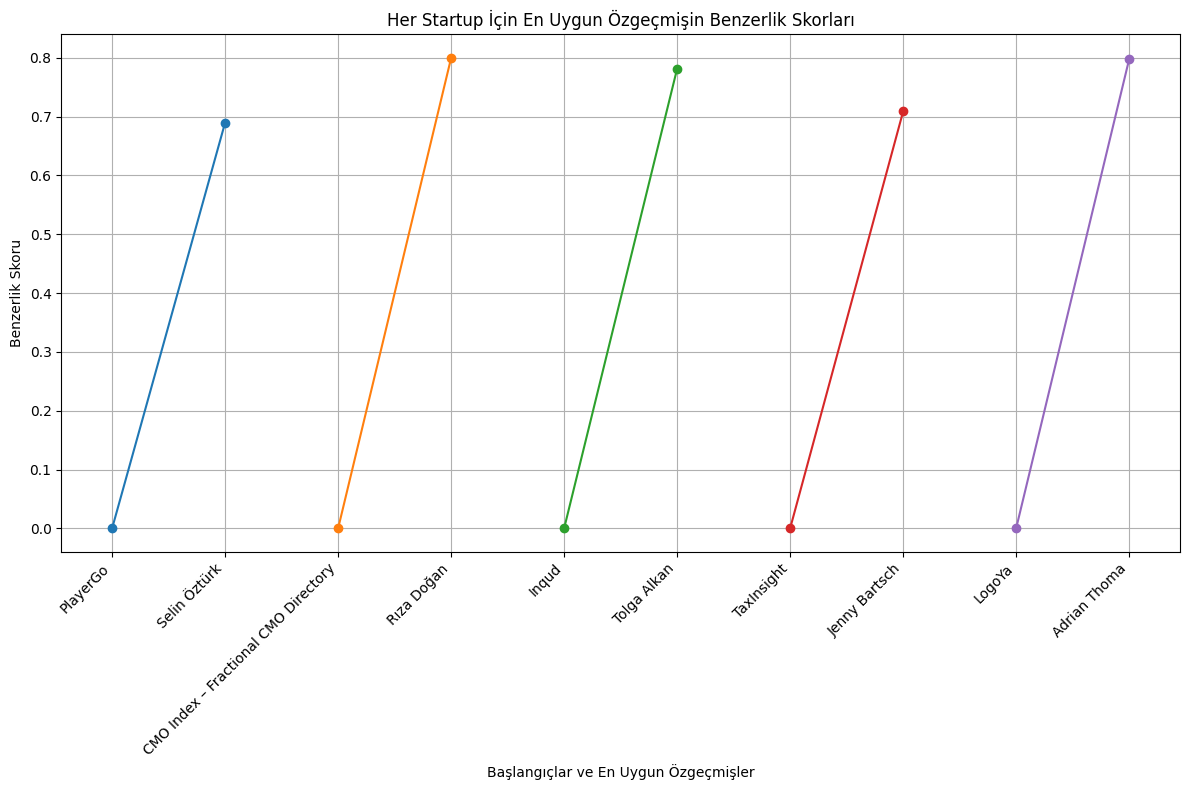

In [19]:
import matplotlib.pyplot as plt

# Başlangıçlar ve en uygun özgeçmişlerin listelerini oluşturun
startup_names = [startup['business_name'] for startup in startup_data[:5]]
best_cv_names = []
scores = []

for i, startup in enumerate(startup_data):
    best_cv, score = find_best_cv_for_startup(i)
    best_cv_names.append(best_cv['name'])
    scores.append(score)

# Grafik oluşturma
plt.figure(figsize=(12, 8))

# Her bir startup için çizgi grafiği çizin
for startup_name, best_cv_name, score in zip(startup_names, best_cv_names, scores):
    plt.plot([startup_name, best_cv_name], [0, score], marker='o', label=f"{startup_name} -> {best_cv_name}")

plt.xlabel('Başlangıçlar ve En Uygun Özgeçmişler')
plt.ylabel('Benzerlik Skoru')
plt.title('Her Startup İçin En Uygun Özgeçmişin Benzerlik Skorları')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()


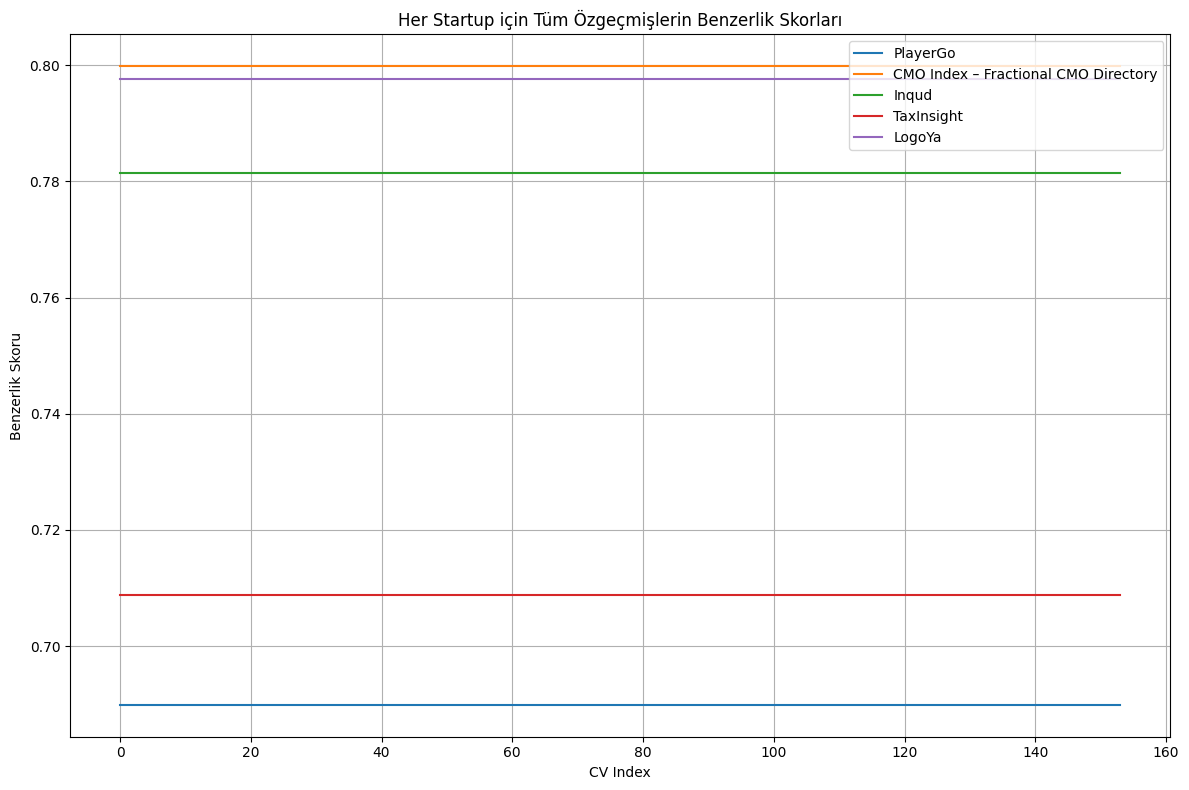

In [27]:
import matplotlib.pyplot as plt

# Her bir startup için tüm özgeçmişlerin uygunluk skorlarını alın
startup_scores = []

for i in range(5):  # İlk 5 startup için
    startup_name = startup_data[i]['business_name']
    scores = []
    for j in range(len(cv_data)):
        _, score = find_best_cv_for_startup(i)
        scores.append(score)
    startup_scores.append(scores)

# Grafik oluşturma
plt.figure(figsize=(12, 8))

# Çizgi grafik çizin
for i in range(5):
    plt.plot(startup_scores[i], label=startup_data[i]['business_name'])

plt.xlabel('CV Index')
plt.ylabel('Benzerlik Skoru')
plt.title('Her Startup için Tüm Özgeçmişlerin Benzerlik Skorları')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
